# Surfing Waves with Sentinel-2: Cross-Spectra & Wavelets on HEALPix Patches

This notebook is a hands-on demo showing how to build **wave spectra** from Sentinel-2 imagery over the ocean using **two 10 m bands** - **B02 (blue)** and **B04 (red)** - that are acquired with a small time offset. That slight offset means the sea surface evolves just enough between the two snapshots to unlock **cross-spectral** estimation: we can both **reduce spectral bias** and **recover wave phase and directions** from the **cross-spectrum**. 

This demo is inspired by the [EOPF sample notebook on oceanographic wave spectral analysis](https://eopf-sample-service.github.io/eopf-sample-notebooks/oceanographic-wave-spectral-analysis/). 

To understand the scientific background for the wave analysis methods used here, refer to:
[Kudryavtsev et al., 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012425).

Instead of classic FFTs on planar tiles, we resample to a **HEALPix** grid so that all patches share the **same surface per pixel**, then estimate spectra with **wavelets**, which are more robust to noise under the assumption that wave spectra are relatively smooth.

---

## Why B02 x B04 Cross-Spectrum?

- Natural temporal offset: B02 and B04 are acquired a few moments apart. Waves evolve slightly - enough to introduce measurable phase differences while maintaining coherence.
- Cross-spectral benefits:
  - Bias reduction in spectral estimates (compared to single-band autospectra).
  - Phase retrieval -> directions: the cross-spectrum’s complex phase gives propagation directions of waves.
- 10 m resolution: fine enough to resolve short waves; the short offset keeps coherence high at these scales.
- This method is inspired by this publication (REF)

---

## Processing Overview

1. **Input**: Sentinel-2 Level-2A/Level-1C oceanic granules containing **B02** and **B04** at **10 m**.  
2. **Patch building (UTM)**: Cut the UTM imagery into fixed **128x128 pixel** patches (~ 1.28 km on a side).  
3. **UTM -> HEALPix**: Resample each patch onto a **HEALPix** grid so that each pixel covers the **same area** regardless of latitude.  
   *Why?* Fair comparisons of spectral energy require consistent pixel areas. It also solve the problem of north-south orientation definition which not properly defined within one UTM tile in particular at the limit of the tile (see bellow how the orientation of UTM pixel is not following the north-south orientation). 
4. **Wavelet-based spectra**: On the HEALPix patch, compute **wavelet transforms** of B02 and B04 and form the **cross-spectrum**:  
   - Smoother, less noise-sensitive than FFTs in this setting.  
   - Provides **amplitude** (power) and **phase** (direction).  
5. **Direction estimation**: Use the **phase** of the cross-spectrum to infer **wave directions** (and optionally phase speed proxies where applicable).  
6. **Scaling up with xbatcher**: Demonstrate how **xbatcher** can tile large scenes and compute many spectra efficiently across lots of Sentinel-2 data.

---

## What You Will Learn

- How to construct UTM **patches** and resample them to **HEALPix** while preserving radiometry.  
- How to compute **wavelet cross-spectra** between B02 and B04 to:  
  - Reduce estimation bias,  
  - Retrieve **directional** information from **phase**.  
- How to use **xbatcher** to scale the workflow (thousands of patches, large scenes).

---

## Notebook Structure

### 1) From UTM Tiles to HEALPix Patches
- **Load** Sentinel-2 B02 & B04 (10 m).  
- **Window** into **128x128** UTM patches over ocean.  
- **Resample** each patch to **HEALPix** (choose `nside` to match resolution/area).  
- **Validate** area equivalence and basic QC checks (land mask, clouds if needed).

### 2) Wavelet Cross-Spectrum on HEALPix
- **Wavelet transform** (per orientation/scale) on both bands.  
- Build **cross-spectrum** as B02 x conj(B04) across **scales** and **orientations**.  
- **Amplitude** -> spectral energy; **phase** -> **wave direction**.  
- **Visualize**:  
  - 2D spectral maps (k-space-like),  
  - Directional roses,  
  - Scale–orientation slices.

### 3) Scaling with xbatcher
- Use **xbatcher** to generate patch windows automatically.  
- Compute **spectra lazily** (e.g., with Dask) and track progress.  
- Aggregate summary products (mean spectra, dominant direction maps, QC flags).

---

## Why Wavelets (Instead of FFTs)?

- Locality in both scale and space helps suppress noise and edge effects.  
- Ocean wave spectra are smooth; wavelets exploit this by emphasizing coherent structures.  
- Better behaved for irregular sampling after **UTM -> HEALPix** resampling.

---

## Practical Notes

- **Band pairing**: Ensure **B02/B04** are radiometrically harmonized (e.g., same masks, scaled units).  
- **Time offset**: The small acquisition lag is a feature, not a bug - enables phase-based direction retrieval.  
- **HEALPix choice**: Pick an `nside` that approximates **10 m** pixels in area (trade-off between fidelity and cost).  
- **Window size**: **128x128** in UTM balances spectral resolution and stationarity.  
- **Compute**: Use **Dask + xbatcher** to parallelize; persist intermediate HEALPix patches if reusing.

---

## Outputs

- **Per-patch spectra**: amplitude and phase across **scales** and **orientations**.  
- **Directional diagnostics**: dominant **wave direction** and spread.  
- **Summary maps** (optional): mosaicked fields of dominant direction/energy.

---

## (Optional) Reproducibility Checklist

- Sentinel-2 L1C/L2A reader (e.g., `rasterio`/`xarray`).  
- HEALPix utilities (e.g., `healpy` or a custom resampler).  
- Wavelet library or custom implementation for **scale–orientation** analysis.  
- `xbatcher` + `dask` for scalable tiling and compute.  
- Plotting: `matplotlib`, optional `cartopy` for geographic overviews.

---

*This demo is an end-to-end recipe: from Sentinel-2 UTM tiles to HEALPix patches, then to robust wave **cross-spectra** via **wavelets**, finishing with a scalable pipeline using **xbatcher**.*

## Contributors
- J.-M. Delouis, LOPS,CNRS-IFREMER-IRD-UBO, Brest, France
- T. Odaka,LOPS,CNRS-IFREMER-IRD-UBO, Brest, France
- A. Fouilloux, VITEN HUB AS, Oslo, Norway

## Install&import all needed packages

- `xarray-eopf` provides a custom xarray backend called `"eopf-zarr"` to open and represent ESA EOPF Zarr data products in a more analysis-ready form.
- `pystac-client` is a Python client (and CLI) for searching and working with STAC APIs and static catalogs, built on PySTAC and adding API search, paging, and conformance handling.
- `xbatcher` provides tools to split large **xarray** datasets into smaller, overlapping patches (batches), enabling scalable analysis and machine learning workflows.  
- `torch` (PyTorch) is a widely used deep learning framework that offers efficient tensor operations, GPU acceleration, and high-level APIs for building and training neural networks. 
- `foscat` is a Python package for synthesizing 2D or spherical (HEALPix) data via the **Cross Wavelet Scattering Transform**, useful in image component separation and denoising. This package also provides anisotropic HEALPix convolution used in this notebook.


In [1]:
!pip install xarray-eopf
!pip install pystac_client
!pip install xbatcher
!pip install torch
!pip install foscat==2025.9.5

In [2]:
import xarray as xr
import pystac_client
import numpy as np
import matplotlib.pyplot as plt

# 1) From UTM Tiles to HEALPix Patches

Creates and displays a local **Dask distributed client**, which launches a scheduler and worker processes on your machine to run computations in parallel and provides access to the interactive Dask dashboard.


In [3]:
from dask.distributed import Client

client = Client()
client

<Client: 'tcp://127.0.0.1:46685' processes=4 threads=8, memory=32.00 GiB>

This cell connects to the **EOPF STAC catalog** to access cloud-optimized Sentinel-2 data, defines the **Bay of Biscay** as the study area with a specific date, and performs a STAC search for **Sentinel-2 L1C scenes** filtered by low cloud cover (<20%) and high sun elevation (>25°) to ensure clear and well-illuminated ocean imagery suitable for wave analysis.

In [4]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis
collections = ["sentinel-2-l1c"]
items = list(
    catalog.search(
        datetime=date,
        collections=collections,
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")
else:
    print("No items found for the given criteria.")

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418
No items found for the given criteria.


This cell selects the first search result (`items[0]`), then lazily opens the associated Sentinel-2 product from object storage as an **xarray DataTree** using the `eopf-zarr` backend, and finally accesses the **B02 (blue) band at 10 m resolution** within the dataset.

In [5]:
item = items[0]
# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)

dt["measurements"]["reflectance"]["r10m"]["b02"]

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.DataArray 'b02' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b02, shape=(10980, 10980), dtype=float64, chunksize=(5490, 5490), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
Attributes: (12)

### Compute Lat/Lon from UTM Grid

This cell reads the dataset’s horizontal CRS code, builds a **pyproj** `CRS` object, and creates a transformer to convert coordinates from the product CRS (typically **UTM**) to **WGS84 (EPSG:4326)**.  

The UTM (Universal Transverse Mercator) system divides the Earth into 60 longitudinal zones and represents positions as **meter-based Easting/Northing** in each zone using a Transverse Mercator projection. UTM is practical for local geometry, but it introduces distortions at the edges of each tile — for example, the definition of the North–South direction becomes less accurate, especially at higher latitudes.  

To overcome these limitations, we convert the UTM grid into a **HEALPix grid**, which provides a consistent, equal-area pixelization of the entire globe. In HEALPix, pixel areas are conserved everywhere on Earth, and directions such as North–South can be defined without the distortions inherent in UTM.  

Before this conversion can be made, the UTM coordinates must first be transformed into a **global latitude/longitude** reference frame so that the data can be correctly mapped to HEALPix indexing.

In [6]:
import pyproj

crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]

# Option 1: let pyproj parse the whole string
src_crs = pyproj.CRS.from_string(crs_code)

# Option 2: strip the prefix and give only the integer
# src_crs = pyproj.CRS.from_epsg(int(crs_code.split(":")[-1]))

transformer = pyproj.Transformer.from_crs(
    src_crs,
    pyproj.CRS.from_epsg(4326),
    always_xy=True
)

For the demo, we reduce the tile size so the workflow runs faster. 

Thanks to **xbatcher**, the computation is automatically **split into smaller patches**, which makes the processing efficient and well-orchestrated across the dataset.  

Because each operation is performed patch by patch, the memory footprint stays low and the notebook can scale to the **entire dataset directly from a laptop**—it’s only a matter of waiting for the results.

In [7]:
size=slice(2*1830,3*1830)
ds=dt["measurements"]["reflectance"]["r10m"].isel(x=size,y=size).persist()
ds

<xarray.DataTree 'r10m'>
Group: /
    Dimensions:  (y: 1830, x: 1830)
    Coordinates:
      * x        (x) int64 15kB 336605 336615 336625 336635 ... 354875 354885 354895
      * y        (y) int64 15kB 5363395 5363385 5363375 ... 5345125 5345115 5345105
    Data variables:
        b02      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b03      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b04      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b08      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

Here we plot the two datasets to illustrate the **global field of view**, but this visualization is intended **only for the demo**.  
When working with a large dataset, this step should be skipped: the data will instead be loaded in **small batches by xbatcher**, ensuring that computations are done piece by piece and that memory usage remains efficient.

Text(0.5, 1.0, 'b04')

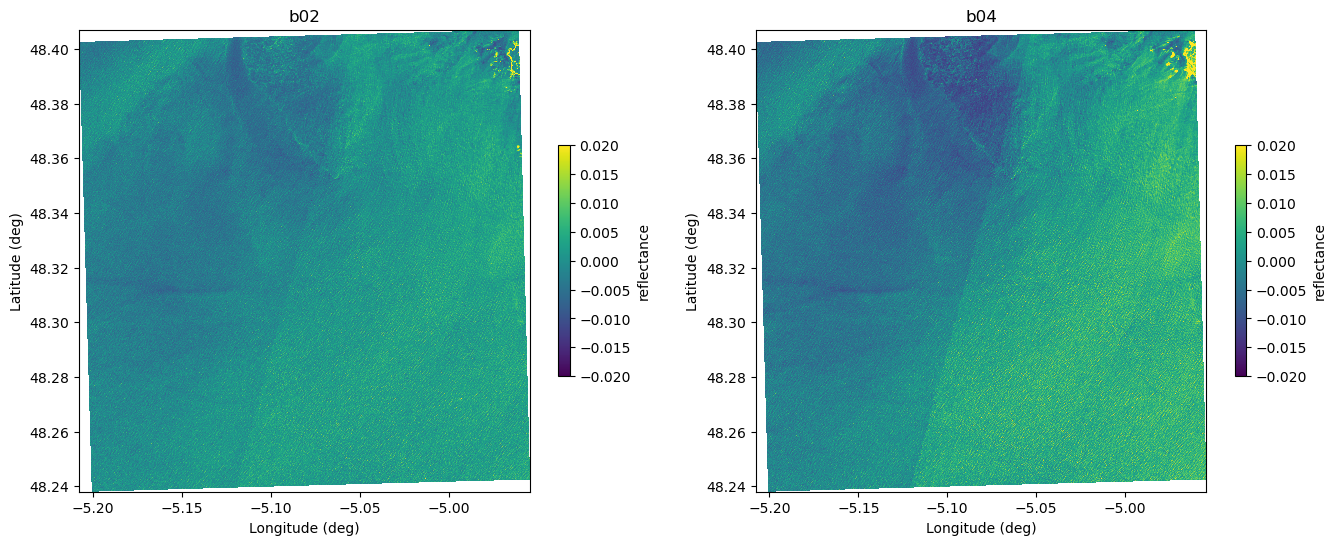

In [8]:
from foscat.Plot import plot_image_latlon

x_vals = ds.x.compute()
y_vals = ds.y.compute() 

# compute coordinate of the patch
xx, yy = np.meshgrid(x_vals, y_vals)
lon, lat = transformer.transform(xx, yy)

fig=plt.figure(figsize=(16,6))

ax=plt.subplot(1,2,1)
plot_image_latlon(fig,ax,ds["b02"].values-np.median(ds["b02"].values), lat, lon, mode="structured", shading="flat",vmin=-0.02,vmax=0.02,aspect="auto")
ax.set_title("b02")
ax=plt.subplot(1,2,2)
plot_image_latlon(fig,ax,ds["b04"].values-np.median(ds["b04"].values), lat, lon, mode="structured", shading="flat",vmin=-0.02,vmax=0.02,aspect="auto")
ax.set_title("b04")


### Key cell — Patch-wise UTM → HEALPix projection with **xbatcher** and inverse interpolation per band

This cell orchestrates a **patch-by-patch** conversion of Sentinel-2 image tiles (in UTM) to a **HEALPix** representation using **xbatcher** for tiling, and a **constrained inverse interpolation** to estimate the value of each HEALPix pixel so that the **HEALPix bilinear interpolation back to the UTM grid** reproduces the original image as closely as possible.

**What it does, step by step**

1. **Batching (xbatcher)**  
   - The UTM image is partitioned into fixed-size patches (`pix_step × pix_step`, default `128×128`).  
   - This keeps memory usage low and enables scalable, parallel processing.

2. **Per-patch coordinate transform**  
   - For each patch, the code builds the (x, y) mesh in UTM, converts it to (lon, lat), and then to spherical angles `(theta, phi)`.

3. **Forward model: HEALPix → UTM via interpolation weights**  
   - Using `healpy.get_interp_weights(nside, theta, phi, nest=True)`, we retrieve, for each UTM pixel center, the **indices** of the HEALPix pixels and the **weights** that HEALPix would use to interpolate **from** HEALPix pixel values **to** that UTM location.  
   - Think of this as building a (very sparse) matrix **A** such that `u_utm ≈ A · v_hp`, where `v_hp` are unknown HEALPix pixel values on this patch footprint, and `u_utm` are the observed UTM pixel values.

4. **Inverse problem (per band)**  
   - For each band (B02 and B04), we **solve the normal equations** `AᵀA v_hp = Aᵀ u_utm` using a **conjugate-gradient** solver (`conjugate_gradient_normal_equation`).  
   - The solution **v_hp** is the set of HEALPix pixel values that, when interpolated with the same weights **A**, best reproduces the original UTM patch (in a least-squares sense).

5. **Quality and stability tweaks**  
   - The code filters cells that do not have enough contributing samples and renormalizes weights to avoid NaNs.  
   - This stabilizes the local inversion, especially along patch borders or near sparse sampling.

6. **Outputs per patch**  
   - `(vals_1, vals_2, cell_ids)`: the reconstructed HEALPix values for B02 and B04 and the corresponding HEALPix cell IDs (NESTED order) touched by the patch.

**Why this is effective**

- The process is **explicitly local and batched** (thanks to xbatcher), so it scales to very large scenes while keeping memory bounded.  
- By **matching the forward interpolation** used by HEALPix, the recovered HEALPix map is directly optimized for later **interpolated queries** (e.g., back to regular grids or to spectral/wavelet operators on the sphere).  
- Solving the **inverse interpolation** rather than simple bin-averaging gives a HEALPix field that is **closest (in least-squares sense)** to the original UTM radiometry when sampled through the same HEALPix interpolant.

<img src="Bi-linear-plot.png" alt="Bi-linear interpolation" style="width:50%;">

**Figure – Forward model and inverse problem between HEALPix and UTM grids.**  
For each UTM pixel center, `healpy.get_interp_weights` provides the indices of the four neighboring HEALPix cells and the corresponding interpolation weights ( $W_0, W_1, W_2, W_3$).  
This defines a sparse linear operator **A** such that `u_utm ≈ A · v_hp`, where `u_utm` are the observed UTM pixel values and `v_hp` are the unknown HEALPix values.  
The inverse problem is then solved per band (B02, B04) by minimizing the least-squares misfit through the conjugate-gradient solution of `AᵀA v_hp = Aᵀ u_utm`, ensuring that the HEALPix map reproduces the UTM data as faithfully as possible under the HEALPix interpolation scheme.



In [9]:
import dask
import xarray as xr
from xbatcher import BatchGenerator
import healpy as hp
import foscat.SphericalStencil as st
from tqdm.auto import tqdm
import numpy as np
from foscat.Plot import conjugate_gradient_normal_equation

# Define a spherical stencil for wavelet processing at a given HEALPix resolution
f = st.SphericalStencil(2**19, 3)


def count_patches(xobj, input_dims, input_overlap):
    """
    Count the total number of windows (patches) generated by xbatcher.
    
    Parameters
    ----------
    xobj : xr.DataArray or xr.Dataset
        The input xarray object with spatial dimensions.
    input_dims : dict
        Window sizes for each dimension.
    input_overlap : dict
        Overlap sizes for each dimension.

    Returns
    -------
    int
        Total number of patches that will be generated.
    """
    stride = {k: input_dims[k] - input_overlap.get(k, 0) for k in input_dims}
    n = 1
    for dim, win in input_dims.items():
        step = stride[dim]
        size = xobj.sizes[dim]
        # number of positions along this dimension = sliding window formula
        n_dim = max(0, (size - win) // step + 1)
        n *= n_dim
    return n


def to_healpix_dask(
    level: int,
    ds: xr.Dataset,
    *,
    pix_step: int = 128,
    transformer=None,
    prefer_kdtree: bool = True,
):
    """
    Build a list of patch results, each computing (vals_b02, vals_b04, cell_ids).
    
    Each patch is extracted in UTM coordinates, then projected into HEALPix.
    The HEALPix values are estimated so that bilinear interpolation of the
    HEALPix map reproduces the original UTM values as closely as possible.
    """
    assert transformer is not None, "You must pass a CRS transformer with .transform(X, Y)."

    band = ds
    assert {"x", "y"} <= set(band.dims)

    pix_step = int(pix_step)
    overlap_y = 0
    overlap_x = 0

    input_dims = {"y": pix_step, "x": pix_step}
    input_overlap = {"y": overlap_y, "x": overlap_x}

    # Safety check: all values must be integers
    for k, v in input_dims.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_dims[{k}] must be int, got {type(v)} -> {v}")
    for k, v in input_overlap.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_overlap[{k}] must be int, got {type(v)} -> {v}")

    # Generator of patches along dimensions (y, x)
    gen = BatchGenerator(
        band,  # input dataset containing bands b02, b04
        input_dims=input_dims,
        input_overlap=input_overlap,
    )

    total = count_patches(band, input_dims, input_overlap)

    def _process_patch(patch_ds, x_vals, y_vals):
        """
        Project one patch from UTM to HEALPix and solve for band values.
        """
        # Ensure x and y coordinates are NumPy arrays
        x_vals = x_vals.compute() if hasattr(x_vals, "compute") else np.asarray(x_vals)
        y_vals = y_vals.compute() if hasattr(y_vals, "compute") else np.asarray(y_vals)

        # Build meshgrid of UTM coordinates
        xx, yy = np.meshgrid(x_vals, y_vals)

        # Convert UTM -> lon/lat
        lon, lat = transformer.transform(xx, yy)

        # Convert lon/lat to HEALPix spherical angles
        theta = np.deg2rad(90.0 - lat).flatten()
        phi   = np.deg2rad(lon).flatten()

        nside = 2**level

        # Compute interpolation indices and weights (HEALPix -> UTM pixels)
        I, W = hp.get_interp_weights(nside, theta, phi, nest=True)

        # Identify unique HEALPix cells and build inverse indices
        cell_ids, indices = np.unique(I, return_inverse=True)

        # Reject cells with too few contributions
        valid_cell = np.bincount(indices.flatten(), W.flatten())
        W *= valid_cell[indices] > 1.0
        W /= np.sum(W, 0)[None, :]
        W[~np.isfinite(W)] = 0.0

        # Recompute valid_cell after cleaning
        valid_cell = np.bincount(indices.flatten(), W.flatten())
        i = 0
        # Find a valid replacement cell index for "empty" slots
        while valid_cell[i] != 0 and i < cell_ids.shape[0] - 1:
            i += 1
        I[valid_cell[indices] == 0] = cell_ids[i]

        # Compute HEALPix cell ids for all (theta, phi)
        cell_ids = hp.ang2pix(nside, theta, phi, nest=True)

        # Re-identify unique cell ids and inverse indices
        cell_ids, indices = np.unique(I, return_inverse=True)

        # Extract band values from the patch
        patch_1 = patch_ds["b02"].values
        patch_2 = patch_ds["b04"].values

        # Solve the inverse interpolation problem for each band
        vals_1 = conjugate_gradient_normal_equation(
            patch_1.flatten(),
            np.zeros([cell_ids.shape[0]]),
            W,
            indices,
            max_iter=100,
            verbose=False,
        )

        vals_2 = conjugate_gradient_normal_equation(
            patch_2.flatten(),
            np.zeros([cell_ids.shape[0]]),
            W,
            indices,
            max_iter=100,
            verbose=False,
        )

        return vals_1, vals_2, cell_ids

    data = []
    for patch in tqdm(gen, total=total, desc="Queuing patches"):
        # Extract coordinate slices for this patch
        x_slice = patch.coords["x"].data
        y_slice = patch.coords["y"].data
        # Process one patch (currently eager; could be wrapped with dask.delayed)
        l_data = _process_patch(patch, x_slice, y_slice)
        data.append(l_data)

    return data

### Build all tiles (UTM → HEALPix, patch by patch)

This cell launches the patch-wise conversion by calling `to_healpix_dask(level=19, ds=ds, pix_step=256, transformer=transformer)`:

it iterates over the Sentinel-2 image in **128×128** UTM patches (via **xbatcher**), converts each patch’s coordinates to **HEALPix**, solves the inverse interpolation for **B02** and **B04**, and returns a Python list where each entry contains the reconstructed HEALPix values and the corresponding cell IDs for that patch—keeping memory low and preparing data for the subsequent spectral analysis.

In [ ]:
# Build all tiles
data = to_healpix_dask(level=19, ds=ds, pix_step=128, transformer=transformer)

Queuing patches:   0%|          | 0/196 [00:00<?, ?it/s]

### Visualize the first HEALPix patches with local gnomonic projection

This cell uses **foscat’s `lgnomproject`** function to display the first four processed patches.  
For each patch, the HEALPix values are projected back onto a local tangent plane (gnomonic projection):

- The **top row** shows B02 results (`data[k][0]`) after subtracting the median to highlight local variations.  
- The **bottom row** shows B04 results (`data[k][1]`) in the same way.  

Both are displayed with the same color scale (`vmin=-0.02`, `vmax=0.02`) for consistent comparison.  
This visualization step is mainly for **demo and sanity-check purposes**: it helps confirm that the HEALPix inversion has preserved the image structure of each patch.

In [ ]:
from foscat.Plot import lgnomproject

plt.figure(figsize=(16,8))
for k in range(4):
    lgnomproject(data[k][2],data[k][0]-np.median(data[k][0]),2**19,hold=False,sub=(2,4,1+k),vmax=0.02,vmin=-0.02)
for k in range(4):
    lgnomproject(data[k][2],data[k][1]-np.median(data[k][1]),2**19,hold=False,sub=(2,4,5+k),vmax=0.02,vmin=-0.02)

# 2) Wavelet Cross-Spectrum on HEALPix

### Multi-scale wavelet analysis to extract wave spectra

We first starts with an exemple to demonstrate the interest to work with wavelets.

### Toy Model: Wavelet Kernels for Wave Spectrum Measurement

In this demonstration, we build a **toy model** of wave spectrum measurement using
a set of 2D oriented wavelet kernels.  
The idea is to simulate how wavelets can capture wave energy and directionality
in an image (or spectrum).  

- Each kernel is constructed as a **Gaussian envelope** multiplied by oscillatory 
  functions (cosine and sine components).  
- Multiple **orientations** are generated by rotating the kernel to cover the 
  angular domain.  
- These wavelet kernels are normalized to have **zero mean** and unit energy, 
  which makes them suitable for spectral analysis.  
- Finally, we display the real (cosine) and imaginary (sine) components of each 
  wavelet to illustrate their directional filtering properties.

In [ ]:
KERNELSZ=7

# Build a 2D meshgrid of size KERNELSZ × KERNELSZ centered on 0
x, y = np.meshgrid(np.arange(KERNELSZ) - KERNELSZ // 2,
                   np.arange(KERNELSZ) - KERNELSZ // 2)

# Number of orientations we want to simulate (rotated versions of the kernel)
no = 8

# Initialize a 4D array to store the kernel set:
#   - orientation index (no different angles)
#   - 2 components (cosine = real, sine = imaginary/quadrature)
#   - spatial kernel of size KERNELSZ × KERNELSZ
ww = np.zeros([no, 2, KERNELSZ, KERNELSZ])

plt.figure(figsize=(16, 3))

for k in range(no):
    # Rotate the grid by angle = 180/no * k
    xx = x * np.cos(np.deg2rad(180 / no * k)) + y * np.sin(np.deg2rad(180 / no * k))
    yy = -x * np.sin(np.deg2rad(180 / no * k)) + y * np.cos(np.deg2rad(180 / no * k))

    # First component: Gaussian envelope × cosine oscillation
    ww[k, 0] = np.exp(-0.1 * (xx**2 + yy**2)) * np.cos(xx * np.pi)

    # Second component: Gaussian envelope × sine oscillation (quadrature component)
    ww[k, 1] = np.exp(-0.1 * (xx**2 + yy**2)) * np.sin(xx * np.pi)

    # Enforce zero-mean property (removes DC component)
    ww[k, 0] -= np.mean(ww[k, 0])
    ww[k, 1] -= np.mean(ww[k, 1])

    # Normalize each kernel so that total energy of (cos² + sin²) = 1
    ww[k] /= np.sqrt(np.sum(ww[k, 0]**2 + ww[k, 1]**2))

    # Display real and imaginary parts of the kernel for this orientation
    plt.subplot(2, no, 1 + k)
    plt.imshow(ww[k, 0])
    plt.title(f"Orient {k} real")
    plt.axis("off")

    plt.subplot(2, no, 1 + no + k)
    plt.imshow(ww[k, 1])
    plt.title(f"Orient {k} imag")
    plt.axis("off")

### Toy Model: Oriented Wavelet Power and Comparison with FFT

This demo synthesizes a **wave field** with a controlled directional spectrum, adds **noise**, and estimates its **directional, multi-scale power** using a bank of **oriented wavelet filters** (cosine/sine quadrature).  
We then compare the wavelet‐based spectra (robust and localized) with the conventional **FFT amplitude spectrum**.  
The multi-scale behavior is emulated by iteratively **downsampling** the image after each scale’s convolution/aggregation step.

In [ ]:
from scipy.signal import convolve2d
from foscat.Plot import power_spectrum_1d,plot_wave

# Example: 128x128 image and 5x5 kernel
# Build a toy "wave model" in spectral domain:
# a directional spectrum peaked at ±k0 along a 45° axis, then inverse-FFT to image space.
X = np.tile(np.arange(128) - 64, 128).reshape(128, 128)
Y = X.T

# Rotate coordinates by 45° to set the preferred propagation direction
x = X * np.cos(np.deg2rad(45)) + Y * np.sin(np.deg2rad(45))
y = -X * np.sin(np.deg2rad(45)) + Y * np.cos(np.deg2rad(45))

# Two Gaussian lobes in frequency: centered at ±16 (toy spatial frequency), with width ~sqrt(16)
wave_spec = np.exp(-((x - 16.0)**2 + y**2) / (2 * 16)) + np.exp(-((x + 16.0)**2 + y**2) / (2 * 16))

# Generate a random phase field and shape its spectrum with wave_spec, then inverse FFT
img = np.fft.ifft2(np.fft.fft2(np.random.randn(128, 128)) *
                   np.roll(np.roll(wave_spec, -64, 0), -64, 1)).real
img /= img.std()  # normalize to unit std for comparability

plt.figure(figsize=(16, 9))

# --- Clean wave field (no noise) -------------------------------------------------
plt.subplot(2, 4, 1)
dx = 128 * 10 / 1000 / 2  # half-domain extent in km (assuming 10 m pixels → 1.28 km domain)
plt.title('Wave model')
plt.imshow(img, extent=[-dx, dx, -dx, dx])
plt.xlabel(r"$x$ [km]")
plt.ylabel(r"$y$ [km]")

# --- Noisy wave field ------------------------------------------------------------
# Add white noise with std=6 (toy level) to stress-test robustness
imgn = img + np.random.randn(128, 128) * 6

plt.subplot(2, 4, 5)
plt.title('Wave model + noise')
plt.imshow(imgn, extent=[-dx, dx, -dx, dx])
plt.xlabel(r"$x$ [km]")
plt.ylabel(r"$y$ [km]")

def comp_wave_spectrum(data):
    """
    Compute a directional, multi-scale wave "power" using a bank of oriented wavelet filters.
    - For each scale: convolve the image with each orientation (cos + i*sin),
      then aggregate power as mean(|response|^2).
    - Emulate a dyadic pyramid by 2×2 averaging + decimation between scales.
    - Duplicate orientation half to cover 0–360° as required by plot_wave.

    Returns
    -------
    result : (6, no*2) array
        scale × orientation power (second half duplicates first half).
    """
    result = np.zeros([6, no * 2])
    l_img = data
    for k in range(6):
        # Directional filtering: complex response = conv with cos + i*sin parts
        for o in range(no):
            l_conv = convolve2d(l_img, ww[o, 0]) + 1J * convolve2d(l_img, ww[o, 1])
            # Power per orientation at this scale (mean energy over pixels)
            result[k, o] = np.mean(abs(l_conv)**2)

        # Dyadic downsampling: average 2x2 blocks to simulate coarser scale
        # (energy is not explicitly renormalized; this is a simple toy pyramid)
        l_img = np.sum(np.sum(l_img.reshape(l_img.shape[0] // 2, 2,
                                            l_img.shape[1] // 2, 2), axis=3), axis=1) / 2

    # Duplicate first half of orientations to cover 0–360° (plot_wave convention)
    result[:, no:] = result[:, 0:no]
    return result

# Wavelet spectra for clean and noisy fields
result  = comp_wave_spectrum(img)
resultn = comp_wave_spectrum(imgn)

# --- Display: heatmaps of scale vs orientation (0–360°) --------------------------
plt.subplot(2, 4, 2)
dx = 128 * 10 / 1000 / 2
plt.imshow(result, extent=[0, 360, 0, result.shape[0]], aspect='auto')
plt.xlabel(r"$\Theta$ [degree]")
plt.ylabel(r"scale order")
plt.colorbar(shrink=0.5)
plt.title('Wavelet')

plt.subplot(2, 4, 6)
dx = 128 * 10 / 1000 / 2
plt.imshow(resultn, extent=[0, 360, 0, result.shape[0]], aspect='auto')
plt.xlabel(r"$\Theta$ [degree]")
plt.ylabel(r"scale order")
plt.colorbar(shrink=0.5)
plt.title('Wavelet with noise')

# --- Polar display compatible with plot_wave() -----------------------------------
plt.subplot(2, 4, 3)
plot_wave(result, title='Wavelet spectrum')

plt.subplot(2, 4, 7)
plot_wave(resultn, title='Wavelet spectrum with noise')

# --- FFT amplitude spectra for comparison ----------------------------------------
plt.subplot(2, 4, 4)
plt.imshow(np.fft.fftshift(abs(np.fft.fft2(img))), extent=[-50, 50, -50, 50])
plt.colorbar(label='Amplitude', shrink=0.5)
plt.xlabel(r"$k_x$ [cycles / km]")
plt.ylabel(r"$k_y$ [cycles / km]")
plt.title('FFT spectrum')

plt.subplot(2, 4, 8)
plt.imshow(np.fft.fftshift(abs(np.fft.fft2(imgn))), extent=[-50, 50, -50, 50])
plt.colorbar(label='Amplitude', shrink=0.5)
plt.xlabel(r"$k_x$ [cycles / km]")
plt.ylabel(r"$k_y$ [cycles / km]")
plt.title('FFT spectrum with noise')

These three cells implement the **core step of wave spectrum estimation** using spherical wavelets applied to the HEALPix-projected Sentinel-2 patches.

1. **Define a directional wavelet kernel**  
   - A small 2D kernel (`KERNELSZ=5`) is built with Gaussian tapering, modulated by sine and cosine oscillations.  
   - This kernel acts like a local wavelet filter sensitive to both **amplitude** and **phase**.  
   - The kernel is normalized and displayed to visualize its two quadrature components (cosine and sine parts).

In [ ]:
KERNELSZ=5

# Build a 2D meshgrid of size KERNELSZ × KERNELSZ centered on 0
x,y=np.meshgrid(np.arange(KERNELSZ)-KERNELSZ//2,
                np.arange(KERNELSZ)-KERNELSZ//2)

# Initialize a 4D array to store the kernel:
# dimensions are (batch=1, real/imag=2, KERNELSZ, KERNELSZ)
ww=np.zeros([1,2,KERNELSZ,KERNELSZ])

# First component: Gaussian envelope × cosine oscillation
ww[0,0]=np.exp(-0.2*(x**2+y**2))*np.cos(x*np.pi)

# Second component: Gaussian envelope × sine oscillation (quadrature)
ww[0,1]=np.exp(-0.2*(x**2+y**2))*np.sin(x*np.pi)

# Remove the mean from each component (to enforce zero-mean wavelet)
ww[0,0]-=np.mean(ww[0,0])
ww[0,1]-=np.mean(ww[0,1])

# Normalize the kernel so that the sum of squares of both components equals 1
ww/=np.sqrt(np.sum(ww[0,0]**2+ww[0,1]**2))

# Display the two components of the kernel
plt.subplot(1,2,1)
plt.imshow(ww[0,0])
plt.subplot(1,2,2)
plt.imshow(ww[0,1])

2. **Wavelet convolution across scales and orientations**  
   - The kernel is converted into a **spherical tensor** so it can be convolved with HEALPix data using the `SphericalStencil` class.  
   - The function `calc_wave_spectrum` applies this kernel to both B02 and B04 band values of a patch.  
   - At each scale:
     - Wavelet coefficients for each orientation are computed.  
     - **Amplitude spectra** for B02 and B04 are obtained as the median of the quadrature magnitude.  
     - The **cross-spectrum amplitude** (coherence between B02 and B04) and the **cross-spectrum phase** (directional phase lag between the two bands) are also calculated.  
   - A multi-scale pyramid is built by repeatedly downsampling the HEALPix resolution (`f.Down`), so spectra are computed at successively coarser scales.


In [ ]:
import foscat.SphericalStencil as st

# Convert the wavelet kernel into a tensor compatible with FOSCAT operations
ww=f.to_tensor(ww.reshape(1,2,KERNELSZ*KERNELSZ))

def calc_wave_spectrum(data_b02,data_b04,cell_ids,ww,
                       number_of_orientation=8,
                       number_of_scale=6,
                       nside=2**19):
    """
    Compute wave spectra from two bands (B02, B04) using spherical wavelet convolutions.
    
    Parameters
    ----------
    data_b02, data_b04 : ndarray
        HEALPix values of the two bands for the patch.
    cell_ids : ndarray
        HEALPix indices corresponding to the patch.
    ww : tensor
        Wavelet kernel (cosine + sine components).
    number_of_orientation : int
        Number of wavelet orientations (angular gauges).
    number_of_scale : int
        Number of dyadic scales for multi-scale analysis.
    nside : int
        HEALPix resolution (power of 2).
    
    Returns
    -------
    wave_a, wave_b : ndarray
        Amplitude spectra for bands B02 and B04.
    wave_cross_amp : ndarray
        Cross-spectrum amplitude between the two bands.
    wave_cross_dir : ndarray
        Cross-spectrum phase (directional information).
    """

    # Initialize spherical stencil operator with orientations ("gauges") along phi
    f=st.SphericalStencil(nside,KERNELSZ,gauge_type='phi',
                          n_gauges=number_of_orientation)

    # Index pairs for cosine/sine quadrature coefficients
    idx_wave=np.arange(number_of_orientation)*2

    # Convert input band values into tensors for convolution
    l_data_a=f.to_tensor(data_b02[None,None,:])
    l_data_b=f.to_tensor(data_b04[None,None,:])
    l_cell_ids = cell_ids
    l_nside=nside

    # Allocate arrays to hold results for each scale and orientation
    wave_a=np.zeros([number_of_scale,number_of_orientation*2])
    wave_b=np.zeros([number_of_scale,number_of_orientation*2])
    wave_cross_amp=np.zeros([number_of_scale,number_of_orientation*2])
    wave_cross_dir=np.zeros([number_of_scale,number_of_orientation*2])

    # Multi-scale loop
    for k in range(number_of_scale):
        # Convolution with wavelet kernel at current scale
        a=f.to_numpy(f.Convol_torch(l_data_a,ww,cell_ids=l_cell_ids,nside=2**19))
        b=f.to_numpy(f.Convol_torch(l_data_b,ww,cell_ids=l_cell_ids,nside=2**19))

        # Amplitude spectrum: sqrt(cos²+sin²), median across pixels
        wave_a[k,0:number_of_orientation]=np.median(np.sqrt(a[0,idx_wave]**2+a[0,idx_wave+1]**2),-1)
        wave_b[k,0:number_of_orientation]=np.median(np.sqrt(b[0,idx_wave]**2+b[0,idx_wave+1]**2),-1)

        # Duplicate amplitudes to cover full 0–360° range
        wave_a[k,number_of_orientation:] = wave_a[k,0:number_of_orientation]
        wave_b[k,number_of_orientation:] = wave_b[k,0:number_of_orientation]
    
        # Cross-spectrum: real and imaginary parts
        val_cross_real=a[0,idx_wave]*b[0,idx_wave]+a[0,idx_wave+1]*b[0,idx_wave+1]
        val_cross_imag=a[0,idx_wave+1]*b[0,idx_wave]-a[0,idx_wave]*b[0,idx_wave+1]

        # Cross-spectrum amplitude = median of real part
        wave_cross_amp[k,:number_of_orientation]=np.median(val_cross_real,-1)
        # Cross-spectrum phase = mean of atan2(imag, real)
        wave_cross_dir[k,:number_of_orientation]=np.mean(np.arctan2(val_cross_imag,val_cross_real),-1)
    
        # Duplicate results for symmetry (180° → 360°)
        wave_cross_amp[k,number_of_orientation:] = wave_cross_amp[k,0:number_of_orientation]
        wave_cross_dir[k,number_of_orientation:] = -wave_cross_dir[k,0:number_of_orientation]
    
        # Downsample HEALPix map to next coarser resolution (dyadic step)
        l_data_a,new_cell_ids=f.Down(l_data_a,cell_ids=l_cell_ids,nside=l_nside)
        l_data_b,new_cell_ids=f.Down(l_data_b,cell_ids=l_cell_ids,nside=l_nside)
    
        # Update working resolution and cell IDs for next scale
        l_nside//=2
        l_cell_ids=new_cell_ids

    return wave_a,wave_b,wave_cross_amp,wave_cross_dir



3. **Visualization of the spectra and patch context**  
   - For each of the first four patches:
     - The amplitude spectra of B02, B04, and their cross-spectrum are displayed as polar plots (`plot_wave`).  
     - The cross-phase spectrum is plotted to reveal the **dominant wave directions**.  
     - Finally, the patch itself (B02 band, median-subtracted) is shown with a local gnomonic projection to visually connect the spatial structure with the extracted spectra.

Together, these steps demonstrate how Sentinel-2 bands can be combined using wavelet analysis on HEALPix grids to derive **robust, multi-scale, and directional estimates of ocean wave spectra** directly from reflectance imagery.

In [ ]:
from foscat.Plot import plot_wave

for k in range(4):
    
    wave_a,wave_b,wave_cross_amp,wave_cross_dir=calc_wave_spectrum(data[k][0],data[k][1],data[k][2],ww)
    
    plt.figure(figsize=(16.0, 3.0))
    plt.subplot(1,5,1)
    plot_wave(wave_a,title='Wave spectrum b02')
    plt.subplot(1,5,2)
    plot_wave(wave_b,title='Wave spectrum b04')
    plt.subplot(1,5,3)
    plot_wave(wave_cross_amp,title='Wave spectrum b02xb04')
    plt.subplot(1,5,4)
    plot_wave(np.rad2deg(wave_cross_dir),unit='Phase',title='Wave Phase b02xb04',cmap="jet")

    lgnomproject(data[k][2],data[k][0]-np.median(data[k][0]),2**19,hold=False,sub=(1,5,5),vmax=0.02,vmin=-0.02,cbar=True,unit=r"$\Delta$ reflectance")

# 3) Scaling with xbatcher

In this section, we demonstrate how the full workflow scales efficiently to large Sentinel-2 scenes using **xbatcher**.  
The computation is split into manageable **patches**, each processed independently and then combined for analysis.

- First, we compute the **geographic coordinates** (longitude and latitude) of each patch center. This allows us to later place the results back into a global reference frame.  
- Next, we derive the **wave spectra** from each patch using the wavelet-based method introduced earlier. Each patch yields a local multi-scale, directional spectrum.  
- Finally, we display the results:
  - On the **left panel**, we plot the reconstructed wave spectra for all patches, mapped into geographic coordinates.  
  - On the **right panel**, we show the original Sentinel-2 B02 reflectance image, so the extracted wave spectra can be visually compared with the observed surface pattern.  

This patch-wise orchestration makes it possible to apply wavelet-based spectral analysis over entire Sentinel-2 tiles while keeping memory usage low and enabling parallel computation.


In [ ]:
def to_wave_dask(
    level: int,
    ds: xr.Dataset,
    *,
    pix_step: int = 128,
    transformer=None,
    prefer_kdtree: bool = True,
):
    """
    Build a list of results per patch.
    For each patch:
      1) Convert UTM pixel centers to (lon, lat) and then to HEALPix angular coords (theta, phi).
      2) Obtain HEALPix→UTM interpolation weights (I, W).
      3) Solve the inverse interpolation to estimate HEALPix values for B02 and B04.
      4) ***Perform multi-scale wavelet analysis (calc_wave_spectrum) on those HEALPix values.***
      5) Return wave spectra and patch center coordinates.
    """
    assert transformer is not None, "You must pass a CRS transformer with .transform(X, Y)."

    band = ds
    assert {"x", "y"} <= set(band.dims)

    # Ensure integer patch size (xbatcher requires ints)
    pix_step = int(pix_step)
    overlap_y = 0
    overlap_x = 0

    input_dims = {"y": int(pix_step), "x": int(pix_step)}
    input_overlap = {"y": int(overlap_y), "x": int(overlap_x)}

    # Safety checks: window & overlap must be integers
    for k, v in input_dims.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_dims[{k}] must be int, got {type(v)} -> {v}")
    for k, v in input_overlap.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_overlap[{k}] must be int, got {type(v)} -> {v}")

    # Patch generator (slides a window over (y, x))
    gen = BatchGenerator(
        band, 
        input_dims=input_dims,
        input_overlap=input_overlap,
    )

    total = count_patches(band, input_dims, input_overlap)
    
    def _process_patch(patch_ds, x_vals, y_vals):
        """
        Process one UTM patch:
          - Build (x, y) -> (lon, lat) -> (theta, phi)
          - Build HEALPix interpolation (I, W)
          - Invert to HEALPix values for B02/B04
          - ***Run wavelet analysis (calc_wave_spectrum) on HEALPix values***
          - Return spectra + patch center (lon/lat)
        """
        # Ensure x/y coordinate arrays are NumPy 1D
        x_vals = x_vals.compute() if hasattr(x_vals, "compute") else np.asarray(x_vals)
        y_vals = y_vals.compute() if hasattr(y_vals, "compute") else np.asarray(y_vals)

        # Build the UTM coordinate mesh for this patch
        xx, yy = np.meshgrid(x_vals, y_vals)

        # UTM -> geographic coordinates
        lon, lat = transformer.transform(xx, yy)

        # Geographic -> spherical angles for HEALPix (theta = colatitude)
        theta = np.deg2rad(90.0 - lat).flatten()
        phi   = np.deg2rad(lon).flatten()

        nside = 2**level

        # --- HEALPix → UTM interpolation model ---
        # I, W are the neighbor indices and bilinear weights used by healpy's interpolation
        I, W = hp.get_interp_weights(nside,theta,phi, nest=True)

        # Reduce to a local set of cells: cell_ids are uniques in I, 'indices' maps each entry of I to [0..len(cell_ids)-1]
        cell_ids, indices = np.unique(I, return_inverse=True)

        # Basic robustness: remove cells with too little support; normalize weights column-wise; avoid NaNs
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        W*=valid_cell[indices]>1.0
        W/=np.sum(W,0)[None,:]
        W[~np.isfinite(W)]=0.0
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        i=0
        while valid_cell[i]!=0 and i<cell_ids.shape[0]-1:
            i+=1
        I[valid_cell[indices]==0]=cell_ids[i]
        
        # Recompute HEALPix cell ids for all query points (theta, phi)
        cell_ids = hp.ang2pix(nside, theta, phi, nest=True)

        # And rebuild local unique ids/indices after the repair step
        cell_ids, indices = np.unique(I, return_inverse=True)
        
        # Extract patch values for both bands (observations on the UTM grid)
        patch_1 = patch_ds["b02"].values 
        patch_2 = patch_ds["b04"].values 
        
        # --- Inverse interpolation (solve for local HEALPix values per band) ---
        # Solve the normal equations so that interpolating HEALPix values with (I, W) reproduces the UTM patch.
        vals_1 = conjugate_gradient_normal_equation(patch_1.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)
        vals_2 = conjugate_gradient_normal_equation(patch_2.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)

        # === WAVELET ANALYSIS (key step) ===
        # Compute multi-scale, multi-orientation wave spectra and cross-spectra on the HEALPix values:
        #   - wave_a: amplitude spectrum for B02
        #   - wave_b: amplitude spectrum for B04
        #   - wave_cross_amp: cross-spectrum amplitude (coherence)
        #   - wave_cross_dir: cross-spectrum phase (direction)
        wave_a,wave_b,wave_cross_amp,wave_cross_dir=calc_wave_spectrum(vals_1,vals_2,cell_ids,ww)
        
        # Return spectra and a representative location for the patch (median lon/lat)
        return wave_a,wave_b,wave_cross_amp,wave_cross_dir,np.median(lon),np.median(lat)

    # Iterate over all patches and collect results (currently eager; could be dask.delayed)
    results = []
    for patch in tqdm(gen, total=total, desc="Queuing patches"):
        x_slice = patch.coords["x"].data
        y_slice = patch.coords["y"].data
        # Single call returning all spectra for this patch
        all_result = _process_patch(patch, x_slice, y_slice)
        results.append(all_result)

    return results

## patch-wise orchestration

In [ ]:
result = to_wave_dask(level=19,
                      ds=ds.isel(x=slice(0,512),y=slice(0,512)), 
                      pix_step=128, 
                      transformer=transformer)

In [ ]:
# Compute the geographic coordinates (lon/lat) corresponding to each processed patch
# Each entry in 'result' contains [..., median_lon, median_lat]
# We extract the last two values (lon, lat) for all patches
center_lon = np.array([k[-2] for k in result])  # longitude of patch centers
center_lat = np.array([k[-1] for k in result])  # latitude of patch centers

### Visualization: Wave Spectra in Geographic Coordinates

In this step we display the **wave spectra reconstructed from each patch** alongside the **original Sentinel-2 image (B02 band)**:

- On the **left panel**, each patch’s polar wave spectrum (scale × orientation) is transformed into a Cartesian wavenumber grid (kx, ky) using `spectrum_polar_to_cartesian`.  
  These spectra are then reprojected into the **geographic frame (lon/lat)** at the patch centers, so we can visualize how the wave energy varies spatially.  

- On the **right panel**, we show the original B02 reflectance field in geographic coordinates for reference.  
  Subtracting the median emphasizes the **wave-like fluctuations** that correspond to the spectral content.

This side-by-side visualization demonstrates how the wavelet spectra extracted from patches can be directly mapped back to their real-world locations.

In [ ]:
from foscat.Plot import lonlat_edges_from_ref, spectrum_polar_to_cartesian

# Create a figure with two panels (spectra on the left, original image on the right)
fig = plt.figure(figsize=(16, 7))

# --- LEFT PANEL: Wave spectra reconstructed from each patch ---
plt.subplot(1, 2, 1)
for k in range(center_lon.shape[0]):
    # Convert the polar wave spectrum (scale × orientation) into a Cartesian (kx, ky) grid
    img, kx, ky = spectrum_polar_to_cartesian(
        result[k][2],                             # polar spectrum from calc_wave_spectrum
        scales=2**np.arange(result[k][2].shape[0]),  # dyadic scales converted to physical size
        scale_kind="size",                        # treat scales as sizes (not frequencies)
        size_to_freq_factor=50.0,                 # conversion factor → cycles/km (~Sentinel-2 resolution)
        method="bicubic",                         # interpolation method for polar→Cartesian mapping
        n_pixels=64,                              # resolution of the output spectrum grid
    )
    
    # Geographic reference for this patch (center latitude/longitude)
    ref_lat = center_lat[k]
    ref_lon = center_lon[k]
    dlon, dlat = 1.5E-4, 1.5E-4   # pixel resolution in degrees (~0.01° ≈ 1.1 km)

    # Compute lon/lat edges corresponding to the projected spectrum image
    lon_e, lat_e = lonlat_edges_from_ref(img.shape, ref_lon, ref_lat, dlon, dlat, anchor="center")

    # Plot the projected wave spectrum at the patch location
    plt.pcolormesh(lon_e, lat_e, img, cmap="jet", shading="flat", vmax=1E-6)

plt.title("Wave spectrum from each patch")

# --- RIGHT PANEL: Original B02 image for context ---
l_ds=ds.isel(x=slice(0,512),y=slice(0,512))
x_vals = l_ds.x.compute()
y_vals = l_ds.y.compute()

# Convert original UTM grid into lon/lat coordinates
xx, yy = np.meshgrid(x_vals, y_vals)
lon, lat = transformer.transform(xx, yy)

# Expand geographic limits to cover all patches
plt.xlim(lon.min() - 64 * dlon, lon.max() + 64 * dlon)
plt.ylim(lat.min() - 64 * dlat, lat.max() + 64 * dlat)

# Plot the B02 reflectance field in geographic coordinates
ax = plt.subplot(1, 2, 2)
plot_image_latlon(
    fig, ax,
    l_ds["b02"].values - np.median(l_ds["b02"].values),  # subtract median to highlight oscillations
    lat, lon,
    mode="structured", shading="flat",
    vmin=-0.02, vmax=0.02, aspect="auto"
)
ax.set_title("b02")